# Depths and Snow Pit Data Package Contents

In [1]:
# import libraries / packages
import os
from pathlib import Path
import glob
import pandas as pd
import numpy as np

#plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook'])


# Download snow depth data from NSIDC
From the SnowEx20 [Depth Probe Landing Page](https://nsidc.org/data/SNEX20_SD/versions/1), you can download data and access the [User's Guide](https://nsidc.org/sites/nsidc.org/files/SNEX20_SD-V001-UserGuide_1.pdf)
<img src="images/SD-landingPage.png">

The Community Snow Depth Probe data package is a single CSV with over 36,000 geolocated snow depths! Three different instrument types were used to measure depths and are recorded in the Measurement Tool column.

Instructions:
1) Click on link to landing page
1) Go to bottom of page
1) Click on download script
1) Save to your snowex21/scripts folder locally

## Programmatically download snow depth data from NSIDC

In [6]:
# Enter the path of the python script location
%run '../scripts/nsidc-download_SNEX20_SD.001_2021-07-13.py' 
print('Grand Mesa 2020 Snow Depth data download complete') 

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=SNEX20_SD&version=001&version=01&version=1&temporal[]=2020-01-28T00:00:00Z,2020-02-12T23:59:59Z

Found 1 matches.
1/2: SnowEx2020_SnowDepths_COGM_alldepths_v01.csv
  [===============                                             ]  25%  4.2MB/s    [==============================                              ]  50%  5.3MB/s    [=============================================               ]  75%  5.9MB/s    [============================================================] 100%  7.2MB/s   
2/2: SnowEx2020_SnowDepths_COGM_alldepths_v01.csv.xml
  [============================================================] 100%  1.4MB/s   
Grand Mesa 2020 Snow Depth data download complete


In [7]:
%%bash

# do some file organizing by moving those files to a new directory
mv *.csv ../data/depths/
mv *.xml ../data/depths/

In [8]:
# show filename in new location:
path = Path('../data/depths/')

for filename in path.glob('*.csv'):
    print(filename.name)

SnowEx2020_SnowDepths_COGM_alldepths_v01.csv


### Read the Depth File

In [9]:
# open depth data file, and create pandas dataframe
df = pd.read_csv(filename, sep=',', header=0, parse_dates=[[2,3]]) #parse the date[2] and time[3] columns such that they are read in as datetime dtypes
    
print('file has been read, and is ready to use.')

file has been read, and is ready to use.


In [10]:
# check data types for each column
df.dtypes

Date (yyyymmdd)_Time (hh:mm, local, MST)                           datetime64[ns]
Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)            object
ID                                                                          int64
PitID                                                                      object
Longitude                                                                 float64
Latitude                                                                  float64
Easting                                                                   float64
Northing                                                                  float64
Depth (cm)                                                                  int64
elevation (m)                                                             float64
equipment                                                                  object
Version Number                                                              int64
dtype: object

### Prep for Data Analysis

In [11]:
# rename some columns for ease further down
df.rename(columns = {
    'Measurement Tool (MP = Magnaprobe; M2 = Mesa 2; PR = Pit Ruler)':'Measurement Tool', 
    'Date (yyyymmdd)_Time (hh:mm, local, MST)': "Datetime"},
          inplace = True)

# set up filter for IOP date range
start = pd.to_datetime('1/28/2020') #first day of GM IOP campaign
end   = pd.to_datetime('2/12/2020') #last day of GM IOP campaign

# filter the IOP date range
df = df[(df['Datetime'] >= start) & (df['Datetime'] <= end)]

print('DataFrame shape is: ', df.shape)
df.head()

DataFrame shape is:  (36388, 12)


,Datetime,Measurement Tool,ID,PitID,Longitude,Latitude,Easting,Northing,Depth (cm),elevation (m),equipment,Version Number
0,2020-01-28 11:48:00,MP,100000,8N58,-108.13515,39.03045,747987.62,4324061.71,94,3148.2,CRREL_B,1
1,2020-01-28 11:48:00,MP,100001,8N58,-108.13516,39.03045,747986.75,4324061.68,74,3148.3,CRREL_B,1
2,2020-01-28 11:48:00,MP,100002,8N58,-108.13517,39.03045,747985.89,4324061.65,90,3148.2,CRREL_B,1
3,2020-01-28 11:48:00,MP,100003,8N58,-108.13519,39.03044,747984.19,4324060.49,87,3148.6,CRREL_B,1
4,2020-01-28 11:48:00,MP,100004,8N58,-108.13519,39.03042,747984.26,4324058.27,90,3150.1,CRREL_B,1


#### Use .groupby() to sort the data set

In [12]:
# group data by the measurement tool 
gb = df.groupby('Measurement Tool', as_index=False).mean().round(1)

# show mean snow depth from each tool
gb[['Measurement Tool', 'Depth (cm)']]

,Measurement Tool,Depth (cm)
0,M2,97.0
1,MP,94.8
2,PR,94.6


#### Find depths associated with a certain measurement tool

In [13]:
print('List of Measurement Tools: ', df['Measurement Tool'].unique())

List of Measurement Tools:  ['MP' 'M2' 'PR']


In [14]:
r = df.loc[df['Measurement Tool'] == 'PR']
print('DataFrame shape is: ', r.shape)
r.head()

DataFrame shape is:  (148, 12)


,Datetime,Measurement Tool,ID,PitID,Longitude,Latitude,Easting,Northing,Depth (cm),elevation (m),equipment,Version Number
37755,2020-01-30 11:24:00,PR,300001,7C15,-108.19593,39.04563,742673.94,4325582.37,100,3048.699951,ruler,1
37756,2020-01-29 15:00:00,PR,300002,6C37,-108.14791,39.00760,746962.00,4321491.00,117,3087.709961,ruler,1
37757,2020-02-09 12:30:00,PR,300003,8C31,-108.16401,39.02144,745520.00,4322983.00,98,3099.639893,ruler,1
37758,2020-01-28 09:13:00,PR,300004,6N18,-108.19103,39.03404,743137.23,4324309.43,92,3055.590088,ruler,1
37760,2020-02-10 10:30:00,PR,300006,8S41,-108.14962,39.01659,746783.00,4322484.00,95,3113.870117,ruler,1


Let's make sure we all have the same pd.DataFrame() again

In [15]:
# pit ruler snow depths from Grand Mesa IOP
r = df.loc[df['Measurement Tool'] == 'PR'] 
print( 'DataFrame is back to only pit ruler depths')

DataFrame is back to only pit ruler depths


### Plotting

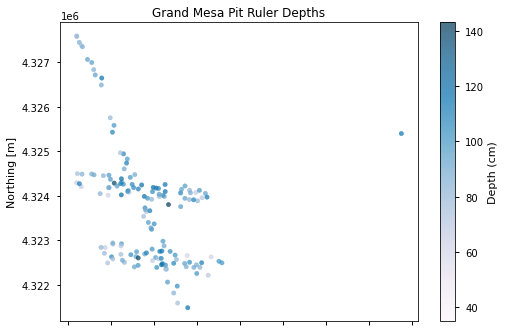

Notice the point on the far right - that is the "GML" or Grand Mesa Lodge pit where all instruments were deployed for a comparison study. pitID=GML


In [16]:
# plot pit ruler depths 
ax = r.plot(x='Easting', y='Northing', c='Depth (cm)', kind='scatter', alpha=0.7, colorbar=True, colormap='PuBu', legend=True)
ax.set_title('Grand Mesa Pit Ruler Depths')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
plt.show()

print('Notice the point on the far right - that is the "GML" or Grand Mesa Lodge pit where all instruments were deployed for a comparison study. pitID=GML')

Text(0, 0.5, 'Frequency')

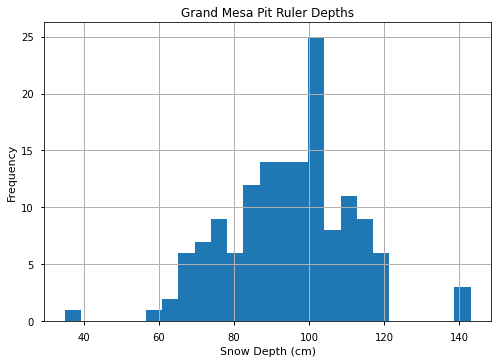

In [17]:
# plot histogram of pit ruler depths
ax = r['Depth (cm)'].plot.hist(bins=25)
ax.grid()
ax.set_title('Grand Mesa Pit Ruler Depths')
ax.set_xlabel('Snow Depth (cm)')
ax.set_ylabel('Frequency')

## Download snow pit data from NSIDC
From the SnowEx20 [Snow Pit Landing Page](https://nsidc.org/data/SNEX20_GM_SP/versions/1), you can download data and access the [User's Guide](https://nsidc.org/data/SNEX20_GM_SP/versions/1). 

<img src="images/SP-landingPage.png">

## Method 1: Programmatically download snow pit data from NSIDC

In [ ]:
# load snow pit data
%run 'scripts/nsidc-download_SNEX20_GM_SP.001.py'
print('Grand Mesa 2020 Snow Pit data download complete')

In [ ]:
# show filenames
path = Path('./data/pits/')

for i, filename in enumerate(path.glob('*5N19*')):
    print(i, filename.name)

## Method 2: Access data from our shared resources server
Again, quick access for hackweek or if you haven't gone through the steps to [configure programmatic access](https://snowex-hackweek.github.io/website/preliminary/earthdata.html#configure-programmatic-access-to-nasa-servers) to NASA servers yet. This pulls data from our AWS, S3 bucket

In [ ]:
# Uses AWS credentials on machine
fs = s3fs.S3FileSystem() 

# which data bucket?
bucket = 'snowex-data'  
      
# contents inside /pits     
flist = fs.ls(f'{bucket}/tutorial-data/core-datasets/pits/')

# which files do we want?
suffix='.csv'

# list comprehension to get .csv files (not .xlsx or .jpgs)
csv_files = [filename for filename in flist if filename.endswith(suffix)]
csv_files[:5]

### Don't want to work with all the files? Method to filter files

In [ ]:
# what files would you like to find?
parameter = 'temperature'
pitID = '5N19'
date = '20200128'

### Read the Pit Parameter File

In [ ]:
with fs.open('/snowex-data/tutorial-data/core-datasets/pits/SnowEx20_SnowPits_GMIOP_{}_{}_{}_v01.csv'.format(date, pitID, parameter), 'rb') as f:
    
    t = pd.read_csv(f, header=7)
t

### Plotting

In [ ]:
# plot temperature
ax = t.plot(x='Temperature (deg C)',y='# Height (cm)', legend=False)
ax.set_aspect(0.4)
ax.grid()
ax.set_title('pit {}: Temperature Profile'.format(pitID))
ax.set_xlabel('Temperature (deg C)')
ax.set_ylabel('Snow Depth (cm)')

In [ ]:
# grab a different pit parameter file
parameter = 'density'
with fs.open('/snowex-data/tutorial-data/core-datasets/pits/SnowEx20_SnowPits_GMIOP_{}_{}_{}_v01.csv'.format(date, pitID, parameter), 'rb') as f:

    d = pd.read_csv(f, header=7)
d

In [ ]:
# get the average density 
d['Avg Density (kg/m3)'] = d[['Density A (kg/m3)', 'Density B (kg/m3)', 'Density C (kg/m3)']].mean(axis=1, skipna=True)
d

In [ ]:
def plot_density(ax, dataframe):
    
    '''
    This function helps you plot density profiles from snow pits. Use it to iterate through 
    DataFrame rows and plot the density for each top and bottom segment.
    
    '''
    
    for index, row in dataframe.iterrows():
        # plot blue bars to represent 10cm density intervals
        top = row['# Top (cm)']
        bottom = row['Bottom (cm)']
        dens = row["Avg Density (kg/m3)"]
        ax.plot([dens, dens],[bottom, top], color='blue', linewidth=4)

        # plot a red cross to show the spread between A and B samples
        densA = row["Density A (kg/m3)"]
        densB = row["Density B (kg/m3)"]
        middle = bottom + 5.
        ax.plot([densA, densB],[middle,middle], color='red')
        
    return ax

fig, ax = plt.subplots()
ax = plot_density(ax, d)
ax.set_xlim(50, 400)
ax.set_ylim(0, 140)
ax.grid(color='lightgray', alpha=.5)
ax.set_aspect(2)
ax.set_title('pit {}: Density Profile'.format(pitID))
ax.set_xlabel('Density kg/m3')
ax.set_ylabel('Snow Depth (cm)')   